In [ ]:
!pip install torchaudio
!pip install transformers
!pip install jiwer
!pip install language-tool-python pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.7 MB/s eta 0:00:00


# Introduction to Libraries

This notebook demonstrates a speech-to-text model implementation using Wav2Vec2 architecture.
Below are the libraries used and their purposes:

- **torchaudio**: For audio preprocessing and data manipulation.
- **torch**: For building and training deep learning models.
- **transformers**: Provides pre-trained models such as Wav2Vec2.
- **jiwer**: For evaluating the model using Word Error Rate (WER).
- **tqdm**: For creating progress bars during processing.

### Installation Instructions
The following libraries need to be installed before executing the notebook:
```bash
!pip install torchaudio transformers jiwer tqdm
```


In [ ]:
import os
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from torch.optim import AdamW
from tqdm import tqdm
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, Wav2Vec2CTCTokenizer
from torch.optim.lr_scheduler import StepLR
from jiwer import wer, cer




# Model Design and Implementation

The model used in this project is **Wav2Vec2ForCTC**, a pretrained speech-to-text architecture from the Hugging Face Transformers library.
It uses a feature extractor and tokenizer to convert raw audio into transcriptions.

### Model Architecture
- Input: Raw audio data (.wav format).
- Processing: Extracts features using Wav2Vec2Processor and passes through a pretrained model.
- Output: Tokenized text sequences, decoded into transcriptions.

Below is the annotated code for the model initialization and a test case to verify its functionality.

In [ ]:
def convert_audio_and_extract_transcripts(root_dir):
    for subdir, _, files in os.walk(root_dir):
        transcript_file = None
        for f in files:
            if f.endswith('.trans.txt'):
                transcript_file = f
                break

        if not transcript_file:
            continue  # No transcript file found, skip this directory

        # Load transcripts into a dictionary
        transcript_path = os.path.join(subdir, transcript_file)
        transcripts = {}
        with open(transcript_path, 'r') as file:
            for line in file:
                parts = line.strip().split(maxsplit=1)
                if len(parts) == 2:
                    file_id, text = parts
                    transcripts[file_id] = text

        # Process each audio file
        for file in files:
            if file.endswith('.flac'):
                # Define paths
                audio_path = os.path.join(subdir, file)
                wav_path = audio_path.replace('.flac', '.wav')
                file_id = file.replace('.flac', '')
                transcript_text = transcripts.get(file_id, "")

                # Convert and save audio
                waveform, sample_rate = torchaudio.load(audio_path)
                if sample_rate != 16000:
                    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
                    waveform = resampler(waveform)
                torchaudio.save(wav_path, waveform, 16000)

                # Save transcript
                transcript_file_path = os.path.join(subdir, file_id + '.txt')
                txt_file.write(transcript_text)

                print(f"Processed {wav_path} and saved transcript to {transcript_file_path}")

# Define the root directory of the dataset
root_directory = "/content/drive/MyDrive/Colab Notebooks/dev-clean"
convert_audio_and_extract_transcripts(root_directory)

- This is Dataset class which converts raw audio and transcript into dataset format, with audio and its corresponding transcript.

In [ ]:


class LibriSpeechDataset(Dataset):
    def __init__(self, root_dir, processor, text_tokenizer_name):
        self.processor = processor
        self.text_tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(text_tokenizer_name)  # Add text tokenizer
        self.samples = []
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".wav"):  # Check for .wav files
                    audio_path = os.path.join(subdir, file)
                    transcript_path = audio_path.replace('.wav', '.txt')  # Match .wav with .txt
                    if os.path.exists(transcript_path):
                        self.samples.append((audio_path, transcript_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        audio_path, transcript_path = self.samples[idx]
        waveform, sample_rate = torchaudio.load(audio_path)
        waveform = waveform.squeeze()

        # Process audio
        input_values = self.processor(
            waveform.numpy(),  # Ensure waveform is passed as a numpy array
            sampling_rate=sample_rate,
            return_tensors="pt"
        ).input_values

        # Process text using the text tokenizer
        with open(transcript_path, 'r') as f:
            transcript = f.read().strip()
        labels = self.text_tokenizer(
            transcript,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).input_ids

        return input_values, labels.squeeze()



# Initialize processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
text_tokenizer_name = "facebook/wav2vec2-base-960h"
# Create the dataset instance
dataset = LibriSpeechDataset(
    root_dir="/content/drive/MyDrive/Colab Notebooks/dev-clean",
    processor=processor,
    text_tokenizer_name=text_tokenizer_name  # Provide the text tokenizer name
)


print(f"Loaded {len(dataset)} samples.")

Loaded 2703 samples.


In [ ]:

# Load pre-trained model
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

# Move model to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
text_tokenizer_name = "facebook/wav2vec2-base-960h"


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

# Dataset validation
- This code makes sure that the dataset is ready to be fed into the pre-trained model through DataLoader.


Number of samples: 2703



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Sample 1:
Audio Path: /content/drive/MyDrive/Colab Notebooks/dev-clean/6345/93302/6345-93302-0026.wav
Transcript Path: /content/drive/MyDrive/Colab Notebooks/dev-clean/6345/93302/6345-93302-0026.txt
Input Values Shape: torch.Size([1, 83040])
Labels Shape: torch.Size([94])

Sample 2:
Audio Path: /content/drive/MyDrive/Colab Notebooks/dev-clean/6345/93302/6345-93302-0022.wav
Transcript Path: /content/drive/MyDrive/Colab Notebooks/dev-clean/6345/93302/6345-93302-0022.txt
Input Values Shape: torch.Size([1, 41120])
Labels Shape: torch.Size([35])

Sample 3:
Audio Path: /content/drive/MyDrive/Colab Notebooks/dev-clean/6345/93302/6345-93302-0009.wav
Transcript Path: /content/drive/MyDrive/Colab Notebooks/dev-clean/6345/93302/6345-93302-0009.txt
Input Values Shape: torch.Size([1, 98000])
Labels Shape: torch.Size([132])

All audio and transcript pairs are matched.

Testing audio processing...
Audio processed: Shape torch.Size([1, 83040])
Testing text processing...
Transcript tokenized: Shape tor

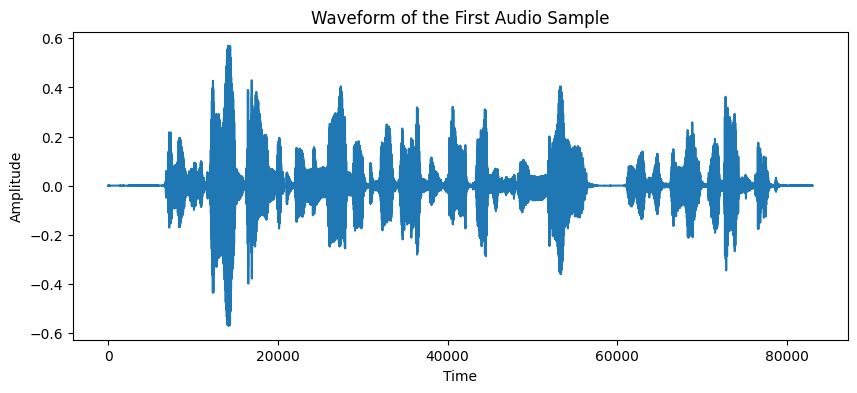

In [ ]:

import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Dataset validation function
def validate_dataset(dataset):
    print(f"Number of samples: {len(dataset)}\n")

    # Check the first few samples
    for i in range(3):
        try:
            input_values, labels = dataset[i]
            print(f"Sample {i+1}:")
            print(f"Audio Path: {dataset.samples[i][0]}")
            print(f"Transcript Path: {dataset.samples[i][1]}")
            print(f"Input Values Shape: {input_values.shape}")  # Audio input shape
            print(f"Labels Shape: {labels.shape}")  # Tokenized transcript shape
            print()
        except Exception as e:
            print(f"Error in sample {i+1}: {e}")

    # Check all transcripts and audio matches
    unmatched_samples = []
    for audio_path, transcript_path in dataset.samples:
        if not os.path.exists(audio_path) or not os.path.exists(transcript_path):
            unmatched_samples.append((audio_path, transcript_path))

    if unmatched_samples:
        print(f"\nUnmatched samples: {len(unmatched_samples)}")
        for audio, transcript in unmatched_samples[:5]:  # Show first 5 unmatched
            print(f"Missing pair: Audio - {audio}, Transcript - {transcript}")
    else:
        print("All audio and transcript pairs are matched.")


    test_audio, _ = dataset.samples[0]
    waveform, sample_rate = torchaudio.load(test_audio)
    print("\nTesting audio processing...")
    input_values = dataset.processor(
        waveform.squeeze().numpy(),
        sampling_rate=sample_rate,
        return_tensors="pt"
    ).input_values
    print(f"Audio processed: Shape {input_values.shape}")

    test_transcript, _ = dataset.samples[0]
    with open(test_transcript.replace(".wav", ".txt"), "r") as f:
        transcript = f.read().strip()
    print("Testing text processing...")
    labels = dataset.text_tokenizer(
        transcript,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).input_ids
    print(f"Transcript tokenized: Shape {labels.shape}")

    # Plot a waveform
    print("\nVisualizing the first audio waveform...")
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.squeeze().numpy())
    plt.title("Waveform of the First Audio Sample")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Initialize processor and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
text_tokenizer_name =  "facebook/wav2vec2-base-960h"
dataset = LibriSpeechDataset(
    root_dir="/content/drive/MyDrive/Colab Notebooks/dev-clean",
    processor=processor,
    text_tokenizer_name=text_tokenizer_name
)

# Validate the dataset
validate_dataset(dataset)


- This function pads the batch of input data to when the batch is used for training.

In [ ]:
def collate_fn(batch):
    input_values = [item[0].squeeze(0) for item in batch]  # Remove batch dimension from input
    labels = [item[1] for item in batch]

    # Pad input_values to the maximum length in the batch
    input_values_padded = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True, padding_value=0)

    # Pad labels to the maximum length in the batch
    labels_padded = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 for ignored tokens

    return input_values_padded, labels_padded

# Optimizer and Scheduler:
-  Configures the AdamW optimizer with a learning rate of 1e-4 and a StepLR scheduler to decay the learning rate by 5% every epoch for better convergence.

# Loss Function and DataLoader:
- Uses the CTC loss function for sequence alignment, and initializes a DataLoader with a batch size of 16 to shuffle and batch the dataset, ensuring padding via collate_fn.

In [ ]:

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

# Specify the loss function
loss_fn = torch.nn.CTCLoss(blank=processor.tokenizer.pad_token_id, zero_infinity=True)
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Decay learning rate every epoch
batch_size = 16  # Adjust based on GPU memory
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


- This training loop runs for 8 epochs, performing forward and backward passes on batches of data to optimize the model using CTC loss, updates weights with AdamW, adjusts the learning rate using a scheduler, and logs the average loss per epoch.

In [ ]:
# Training loop
epochs = 8  # Number of epochs
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in data_loader:
        # Unpack batch
        input_values, labels = batch
        input_values, labels = input_values.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_values, labels=labels)
        loss = outputs.loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Step scheduler
    scheduler.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data_loader):.4f}")


Epoch 1/8, Loss: 304.8034
Epoch 2/8, Loss: 178.3894
Epoch 3/8, Loss: 168.8464
Epoch 4/8, Loss: 170.7791
Epoch 5/8, Loss: 138.7332
Epoch 6/8, Loss: 167.9188
Epoch 7/8, Loss: 134.2635
Epoch 8/8, Loss: 114.4739


# Saving the model
- The model that was fine-tuned and the processor, which was used both were saved in the folder which the path points out.

In [ ]:
# Save model and processor
model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/fine_tuned_wav2vec2")
processor.save_pretrained("/content/drive/MyDrive/Colab Notebooks/fine_tuned_wav2vec2_processor")

print("Model and processor saved successfully!")


Model and processor saved successfully!


- The model is again called to generate the text description of the test audio.

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Replace with the paths where your fine-tuned model and processor are saved
model_path = "/content/drive/MyDrive/Colab Notebooks/fine_tuned_wav2vec2"
processor_path = "/content/drive/MyDrive/Colab Notebooks/fine_tuned_wav2vec2_processor"

# Load the model and processor
model_1 = Wav2Vec2ForCTC.from_pretrained(model_path)
processor_1 = Wav2Vec2Processor.from_pretrained(processor_path)

print("Fine-tuned model and processor loaded successfully!")


Fine-tuned model and processor loaded successfully!


In [ ]:
from torch.utils.data import random_split

# Assuming `dataset` is your existing PyTorch Dataset
dataset_size = len(dataset)
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
from torch.utils.data import DataLoader

# Training DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [ ]:
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Training set size: 2163
Validation set size: 540


In [ ]:
from jiwer import wer, cer

def evaluate_model(model, processor, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_references = []

    with torch.no_grad():
        for batch in data_loader:
            input_values, labels = batch
            input_values = input_values.to(device)
            labels = labels.to(device)

            # Get logits from the model
            logits = model(input_values).logits
            predicted_ids = torch.argmax(logits, dim=-1)

            # Decode predictions
            predictions = processor.batch_decode(predicted_ids, skip_special_tokens=True)

            # Decode references
            references = processor.batch_decode(labels, group_tokens=False)

            all_predictions.extend(predictions)
            all_references.extend(references)

    # Compute WER and CER
    word_error_rate = wer(all_references, all_predictions)
    character_error_rate = cer(all_references, all_predictions)

    return word_error_rate, character_error_rate, all_predictions, all_references


In [ ]:
wer_score, cer_score, all_predictions, all_references = evaluate_model(model_1, processor_1, val_loader, device)


In [ ]:
def clean_text(text):
    # Remove <unk> tokens
    text = text.replace("<unk>", "")
    # Remove extra spaces
    text = " ".join(text.split())
    return text


In [ ]:
cleaned_references = [clean_text(ref) for ref in all_references]
cleaned_predictions = [clean_text(pred) for pred in all_predictions]



In [ ]:
import re

def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    # Remove extra spaces
    text = " ".join(text.split())
    return text

normalized_references = [normalize_text(ref) for ref in cleaned_references]
normalized_predictions = [normalize_text(pred) for pred in cleaned_predictions]


In [ ]:

# Recalculate metrics
word_error_rate = wer(normalized_references, normalized_predictions)
character_error_rate = cer(normalized_references, normalized_predictions
                           )

print(f"Normalized Word Error Rate (WER): {word_error_rate:.2%}")
print(f"Normalized Character Error Rate (CER): {character_error_rate:.2%}")


Normalized Word Error Rate (WER): 13.13%
Normalized Character Error Rate (CER): 3.05%


In [ ]:
import torchaudio

def load_audio(audio_path):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Resample if the audio is not 16kHz
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    return waveform.squeeze().numpy()  # Return as a NumPy array


In [ ]:
import torch

def transcribe_audio(audio_path, model, processor):
    # Determine the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load and preprocess the audio
    audio = load_audio(audio_path)

    # Process the audio input
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs["input_values"] = inputs["input_values"].to(device)  # Move input_values to the same device as the model

    # Move model to the device
    model = model.to(device)

    # Predict
    with torch.no_grad():
        logits = model(inputs["input_values"]).logits  # Access input_values explicitly

    # Decode the predictions
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

    return transcription


In [ ]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/twin-peaks-fire-walk-with-me.wav"  # Replace with your actual audio file path
transcription = transcribe_audio(audio_path, model_1, processor_1)
print("Transcription:", transcription)


Transcription: THROUGH THE DARKNES OF FUTURE PAST THE MAGICIAN LONGS TO SEONE CHANCE A BETWEN TWO WORKSFIREWALK WITH ME


In [ ]:
!pip install torch transformers nltk


In [ ]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

from nltk.tokenize import sent_tokenize

def split_into_sentences(text):
    return sent_tokenize(text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def encode_sentences(sentences):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token embedding
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Shape: [1, hidden_size]
        embeddings.append(cls_embedding.squeeze().numpy())
    return embeddings


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rank_sentences(embeddings, sentences, num_sentences=3):
    # Compute similarity to the mean embedding
    mean_embedding = np.mean(embeddings, axis=0).reshape(1, -1)
    similarities = cosine_similarity(embeddings, mean_embedding).flatten()

    # Rank sentences by similarity
    ranked_indices = np.argsort(similarities)[::-1]
    top_indices = ranked_indices[:num_sentences]

    # Return top sentences
    summary = [sentences[i] for i in top_indices]
    return " ".join(summary)


In [ ]:
def bertsum_summary(text, num_sentences=3):
    # Step 1: Split into sentences
    sentences = split_into_sentences(text)

    # Step 2: Encode sentences
    embeddings = encode_sentences(sentences)

    # Step 3: Rank sentences and generate summary
    summary = rank_sentences(embeddings, sentences, num_sentences)
    return summary


In [ ]:
text = """
Artificial intelligence is transforming the way we interact with technology.
AI-driven tools are now embedded in everyday devices.
With advancements in deep learning, new possibilities are emerging.
Natural language processing is improving virtual assistants like Siri and Alexa.
Autonomous vehicles and predictive analytics are just a few examples of AI's impact.
"""

extractive_summary = bertsum_summary(transcription, num_sentences=2)
print("Summary:")
print(extractive_summary)


Summary:
THROUGH THE DARKNES OF FUTURE PAST THE MAGICIAN LONGS TO SEONE CHANCE A BETWEN TWO WORKSFIREWALK WITH ME


In [ ]:
from transformers import pipeline

# Load BART summarization pipeline
abstractive_summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)  # Enable GPU with device=0

# Function for abstractive summarization from an extractive summary
def abstractive_summary_from_extractive(extractive_summary, summarizer):
    # Dynamic length adjustment based on input length
    max_len = min(len(extractive_summary.split()) + 10, 50)
    min_len = max(10, int(0.3 * len(extractive_summary.split())))

    # Generate abstractive summary
    return summarizer(extractive_summary, max_length=max_len, min_length=min_len, do_sample=False)[0]['summary_text']

# Example: Extractive summary
#extractive_summary = "AI-driven tools are now embedded in everyday devices. Autonomous vehicles and predictive analytics are just a few examples."

# Generate abstractive summary
final_abstractive_summary = abstractive_summary_from_extractive(extractive_summary, abstractive_summarizer)
print("Final Abstractive Summary:", final_abstractive_summary)


Final Abstractive Summary: One Chance To See You In The Dark is published by Simon & Schuster at £16.99. The film is directed


!pip install rogue_score

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5dc1f70abb4c778564a81fed389daaeb43900289152e610c532a7178d793438c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
from rouge_score import rouge_scorer

# Function to calculate ROUGE scores
def compute_rouge(reference, generated):
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Compute scores
    scores = scorer.score(reference, generated)
    return scores

# Example
reference_summary = "THROUGH THE DARKNES OF FUTURE PAST THE MAGICIAN LONGS TO SEONE CHANCE A BETWEN TWO WORKSFIREWALK WITH ME"
generated_summary = "One Chance To See You In The Dark is published by Simon & Schuster at £16.99. The film is directed"

# Compute ROUGE scores
rouge_scores = compute_rouge(reference_summary, generated_summary)

# Display the results
print("ROUGE-1:", rouge_scores['rouge1'])
print("ROUGE-2:", rouge_scores['rouge2'])
print("ROUGE-L:", rouge_scores['rougeL'])


ROUGE-1: Score(precision=0.2, recall=0.2222222222222222, fmeasure=0.2105263157894737)
ROUGE-2: Score(precision=0.0, recall=0.0, fmeasure=0.0)
ROUGE-L: Score(precision=0.1, recall=0.1111111111111111, fmeasure=0.10526315789473685)
